<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [3]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!curl "https://drive.usercontent.google.com/download?id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF&confirm=xxx" -o hw2_data.zip
!unzip -qq hw2_data.zip -d deepul/homeworks/hw2/data
!pip install ./deepul
from deepul.hw2_helper import *

Cloning into 'deepul'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 254 (delta 46), reused 32 (delta 32), pack-reused 182 (from 1)
Receiving objects: 100% (254/254), 94.70 MiB | 2.64 MiB/s, done.
Resolving deltas: 100% (95/95), done.
Updating files: 100% (149/149), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1652  100  1652    0     0   5977      0 --:--:-- --:--:-- --:--:--  6007
[hw2_data.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of hw2_data.zip or
        hw2_data.zip.zip, and cannot find hw2_data.

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


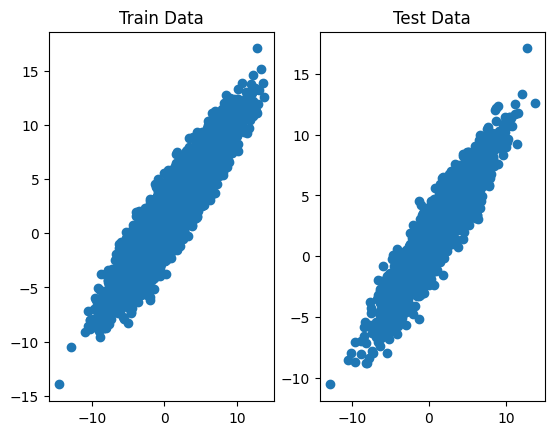

Dataset 2


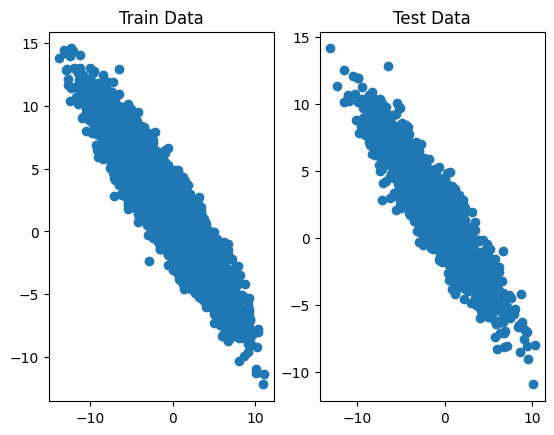

In [4]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [8]:
import torch
import torch.nn as nn 


class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()

        self.encoder_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # one layer for the mean, one for log variance (numerical stability)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        hidden = self.encoder_net(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # eps ~ N(0,1) -> random numbers from N(0,1)
        z = mu + eps * std

        return z

In [14]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, img_data_src: bool=False, eps: float = 1e-6):
        super().__init__()

        self.decoder_net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(hidden_dim, output_dim)
        self.fc_logvar = nn.Linear(hidden_dim, output_dim)

        self.img_data_src: bool = img_data_src
        self.eps = eps

    def forward(self, z):
        hidden = self.decoder_net(z)
        # sigmoid to bound data in range [0, 1]
        if self.img_data_src:
            mu = torch.sigmoid(self.fc_mu(hidden))
        else:
            mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden) + self.eps # eps to avoid log(0) = undefined

        return mu, logvar

    def sample(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

In [ ]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """
    input_dim = 2  
    hidden_dim = 32 
    latent_dim = 2  
    lr = 1e-3
    batch_size = 128
    n_epochs = 50
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_tensor = torch.FloatTensor(train_data).to(device)
    test_tensor = torch.FloatTensor(test_data).to(device)
    train_dataset = torch.utils.data.TensorDataset(train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    encoder = Encoder(input_dim, hidden_dim, latent_dim).to(device)
    decoder = Decoder(latent_dim, hidden_dim, input_dim).to(device)

    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

    train_metrics = []  # [ELBO, recon, KL] for each minibatch
    epoch_metrics = []  # [ELBO, recon, KL] for each epoch

    # 6. Fonction de calcul de loss
    def compute_loss(x, return_components=False):
        # Encode
        mu_z, logvar_z = encoder(x)
        z = encoder.reparameterize(mu_z, logvar_z)
        
        # Decode
        mu_x, logvar_x = decoder(z)
        
        # Reconstruction loss (log likelihood)
        recon_loss = -torch.sum(
            -0.5 * logvar_x - 0.5 * torch.exp(-logvar_x) * (x - mu_x)**2, 
            dim=1
        ).mean()
        
        # KL divergence
        kl_loss = -0.5 * torch.sum(
            1 + logvar_z - mu_z.pow(2) - logvar_z.exp(),
            dim=1
        ).mean()
        
        # Total loss (negative ELBO)
        loss = recon_loss + kl_loss
        
        if return_components:
            return loss, recon_loss, kl_loss
        return loss

    def train_epoch():
        encoder.train()
        decoder.train()
        for batch, in train_loader:
            optimizer.zero_grad()
            loss, recon, kl = compute_loss(batch, return_components=True)
            loss.backward()
            optimizer.step()
            train_metrics.append([loss.item(), recon.item(), kl.item()])

    def evaluate():
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            loss, recon, kl = compute_loss(test_tensor, return_components=True)
            return loss.item(), recon.item(), kl.item()

    epoch_metrics.append(evaluate()) 
    for epoch in range(n_epochs):
        train_epoch()
        epoch_metrics.append(evaluate())

    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        z = torch.randn(1000, latent_dim).to(device)
        mu_x, logvar_x = decoder(z)
        samples_with_noise = decoder.sample(mu_x, logvar_x).cpu().numpy()
        
        samples_without_noise = mu_x.cpu().numpy()

    return (np.array(train_metrics),
            np.array(epoch_metrics),
            samples_with_noise,
            samples_without_noise)

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Final -ELBO: 2.7508, Recon Loss: 1.1604, KL Loss: 1.5904


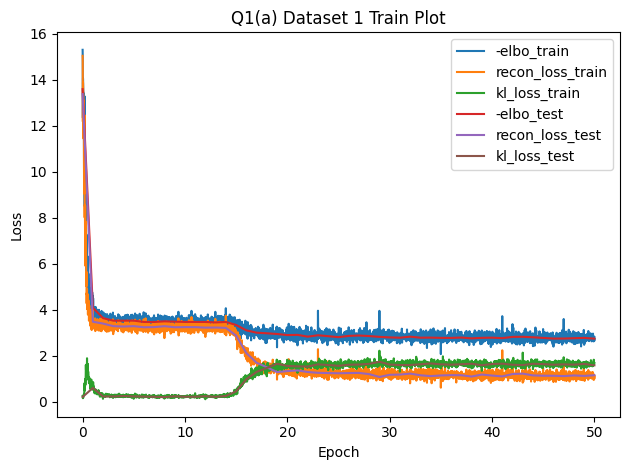

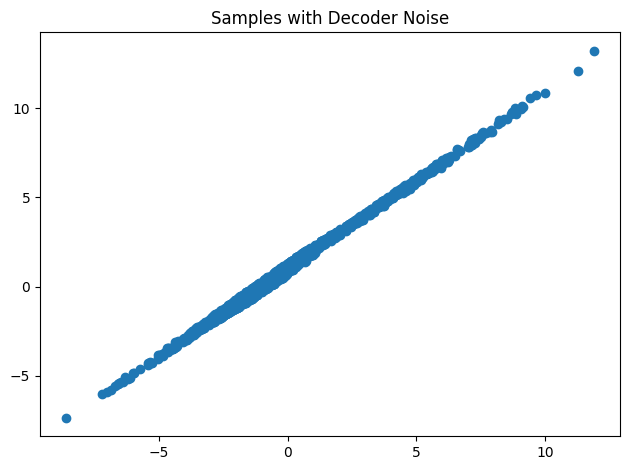

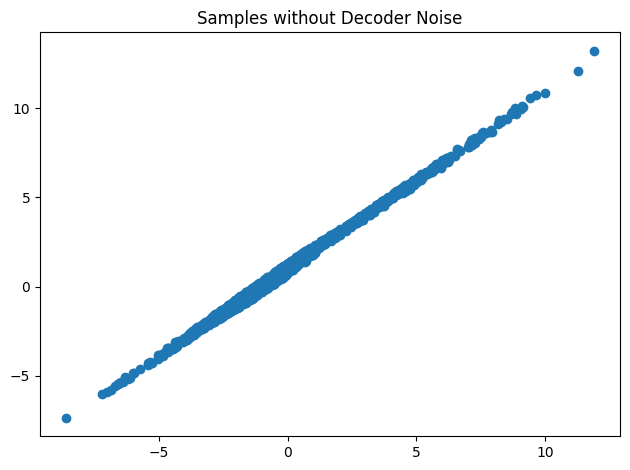

In [16]:
q1_save_results('a', 1, q1)

Final -ELBO: 2.5963, Recon Loss: 0.9944, KL Loss: 1.6019


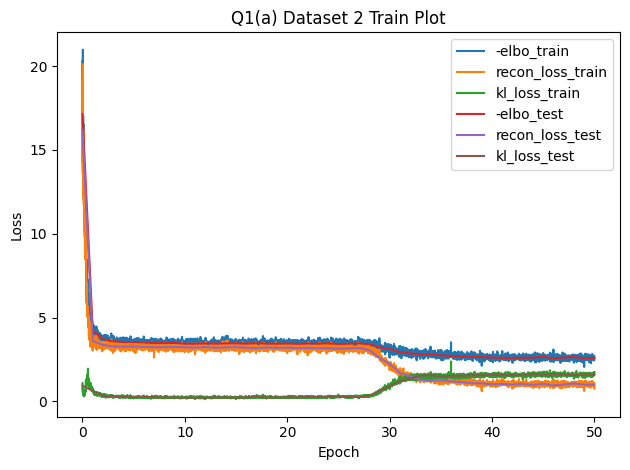

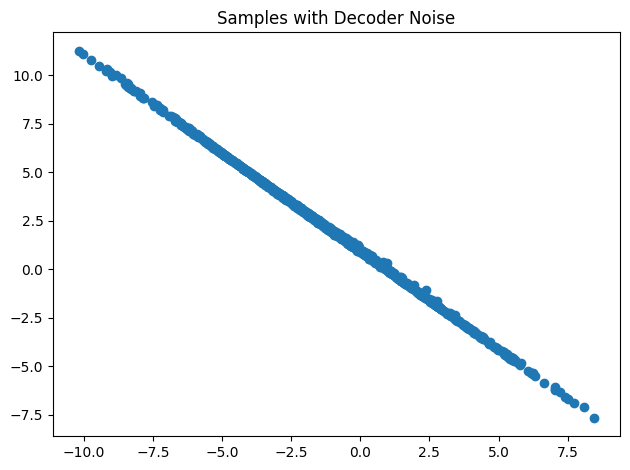

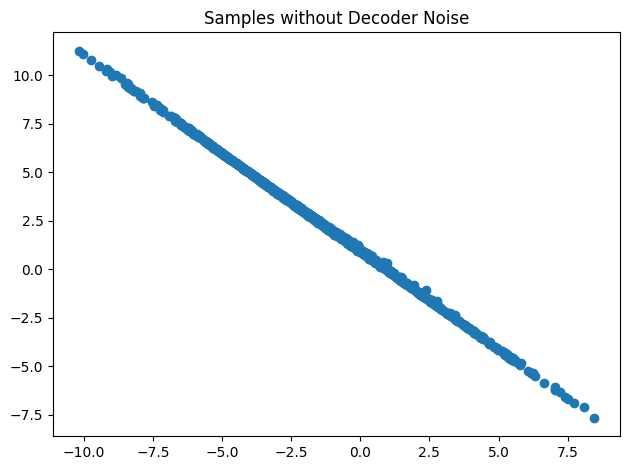

In [17]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


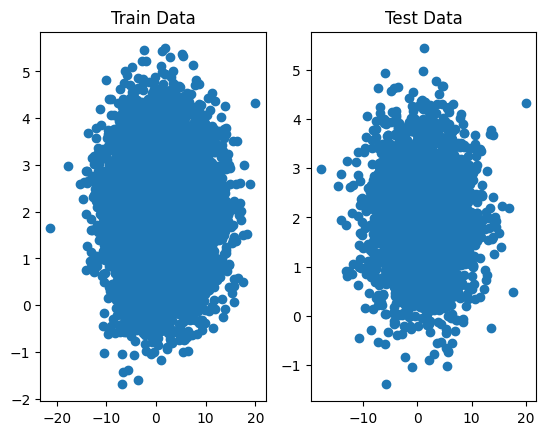

Dataset 2


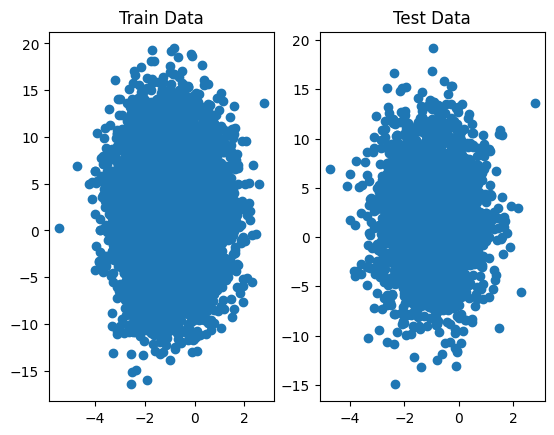

In [5]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

Final -ELBO: 2.5846, Recon Loss: 2.5816, KL Loss: 0.0031


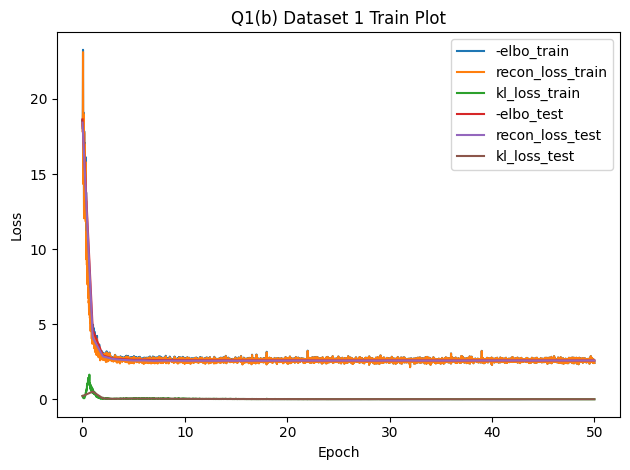

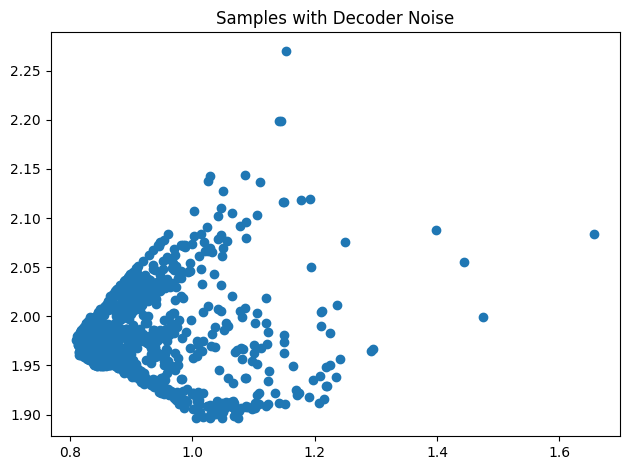

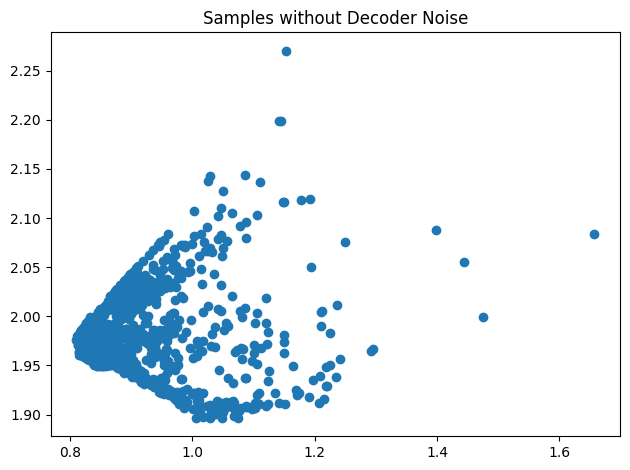

In [18]:
q1_save_results('b', 1, q1)

Final -ELBO: 2.5836, Recon Loss: 2.5727, KL Loss: 0.0108


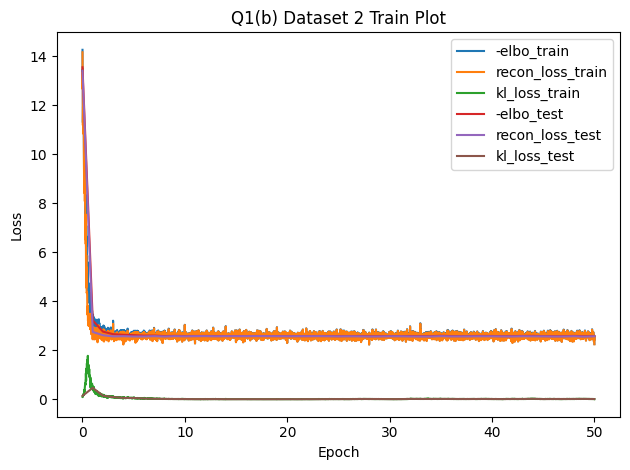

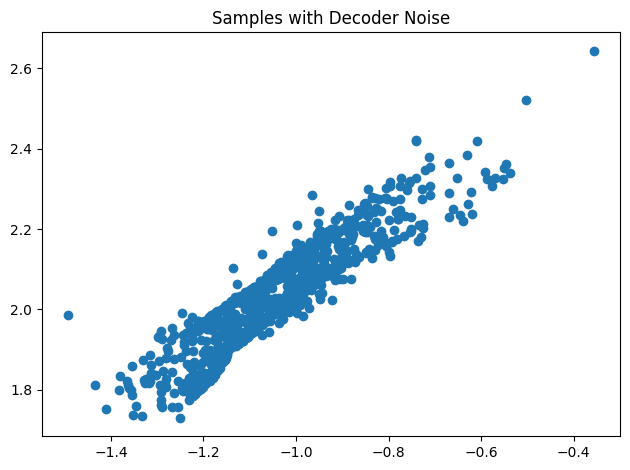

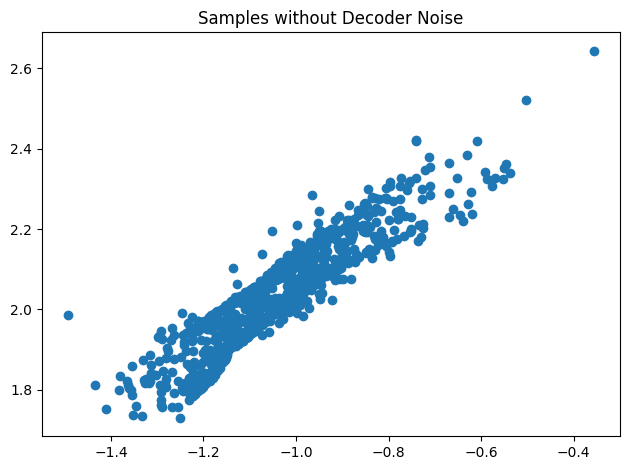

In [19]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

In [6]:
visualize_svhn()
visualize_cifar10()

FileNotFoundError: [Errno 2] No such file or directory: 'deepul/homeworks/hw2/data/svhn.pkl'

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

In [ ]:
q2_save_results('a', 1, q2_a)

In [ ]:
q2_save_results('a', 2, q2_a)

## Part (b) Hierarchical VAE [20pts]

In this part, we will explore a simplified version of the hierarchical VAE described in [NVAE](https://arxiv.org/pdf/2007.03898.pdf). We will not implement the full NVAE, but rather use some ideas from the paper to explore how to learn a prior distribution p(z).

Implement a hierarchical VAE that follows the following structure.
* $z1$ is a 2x2x12 latent vector where p(z1) is the unit Gaussian.
    * Learn the approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix. I.e., same as a normal VAE, but use a matrix latent rather than a vector. Each dimension is independent.
* $z2$ is a 2x2x12 latent vector.
    * $p_\theta(z2|z1)$ is learned, and implemented as a neural network that parameterizes mean (and log std, optionally).
    * $q_\theta(z2|z1,x)$ is also learned. Implement this as a Residual Normal [see NVAE] over the prior $p_\theta(z2|z1)$.
* The decoder should be a function of $z2$ only.

Some helpful hints:
* Two KL losses should be calculated. The first should match $q_\theta(z|x)$ to the unit Gaussian. The second should match $q_\theta(z2|z1,x)$ and $p_\theta(z2|z1)$, and be taken with respect to $q$.
* When calculating the second KL term, utilize the analytic form for the residual normal. When $q_\theta(z2|z1,x) = N(z2; \mu_\theta(z1) + \Delta \mu_\theta(z1,x), \Sigma_\theta(z1)) * \Delta \Sigma_\theta(z1,x))$, use the following form: `kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5`
* When calculating KL, remember to sum over the dimensions of the latent variable before taking the mean over batch.
* For the prior $p_\theta(z2|z1)$, fix standard deviation to be 1. Learn only the mean. This will help with stability in training.

The following network structures may be useful:
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
        nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
        LayerNorm(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
We assume encoder networks are of the form p(z'|z,x).
When learning q(z1), an x of all zeros can be used as input.
Upscale z with nearest-neighbor projection before concatenating with x.


Decoder
        nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
        nn.ReLU(),
        nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
```


**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

In [ ]:
q2_save_results('b', 1, q2_b)

In [ ]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a Transformer prior on the categorical latents in order to sample. Feel free to use your implementation for HW1! You should flatten the VQ-VAE tokens into a [H x W] sequence, and use a start token.

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and Transformer prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and Transformer prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE test losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of Transformer prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of Transformer prior test losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

In [ ]:
q3_save_results(1, q3)

In [ ]:
q3_save_results(2, q3)

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)